In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from const import observation_length
from env_fx import EnvFx

In [4]:
env = EnvFx(
    '/mnt/Omer/Project/10.AdaptivePacing/dst/npy/USDJPY.npy',
    spread=0.,
    min_act_interval=4,
    load_interval=1440*30)

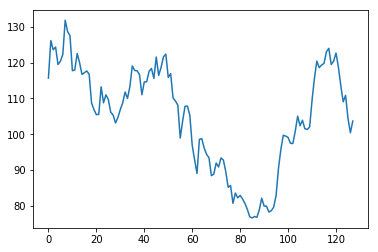

In [5]:
env.reset()
env.update(0)
env.draw()

In [6]:
L = len(env.history)
L_train = int(L * 0.8)
L, L_train

(150, 120)

In [108]:
pred_distance = 10

price_min = env.history.min()
price_width = env.history.max() -price_min

def normalize(x):
    return (x-price_min)/price_width


def make_dataset(env):
    
    data, target = [],[]
    
    for i in range(L_train):
        action = np.random.randint(0,4)
        env.update(action)
        data.append(env.screen)
        target.append(env.history[env.time_step+pred_distance])
        
    data = np.array(data).reshape(len(data), observation_length, 1)
    target = np.array(target).reshape(len(data), 1)
    train = {'data':normalize(data), 'target':normalize(target)}
    
    data, target = [],[]
    for i in range(L_train, L - pred_distance - observation_length):
        action = np.random.randint(0,4)
        env.update(action)
        if env.terminal: break
        data.append(env.screen)
        target.append(env.history[env.time_step+pred_distance])
        
    data = np.array(data).reshape(len(data), observation_length, 1)
    target = np.array(target).reshape(len(data), 1)
    test = {'data':normalize(data), 'target':normalize(target)}
    
    return train, test
        

In [109]:
env.reset()
train, test = make_dataset(env)

In [110]:
test['target'].shape

(757, 1)

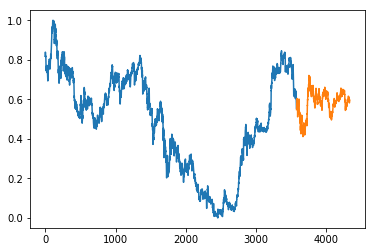

In [111]:
y = train['target'][:,0]
y_ = test['target'][:,0]
plt.plot(np.arange(len(y)), y)
plt.plot(np.arange(len(y_))+len(y), y_)

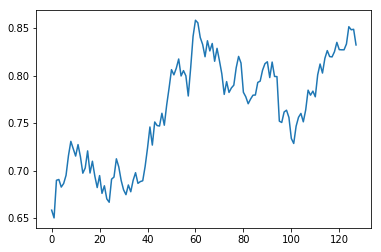

In [112]:
plt.plot(train['data'][0,:,0])

In [113]:
model = Sequential()
model.add(LSTM(observation_length, batch_input_shape=(None, observation_length, 1), return_sequences=False))
model.add(Dense(1))
model.add(Activation("relu"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

In [114]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
model.fit(train["data"], train["target"],
          batch_size=300,
          epochs=10,
          validation_split=0.1,
          callbacks=[early_stopping]
          )

Train on 3218 samples, validate on 358 samples
Epoch 1/10
3218/3218 [==============================] - 5s 2ms/step - loss: 0.0725 - val_loss: 0.0019
Epoch 2/10
3218/3218 [==============================] - 3s 872us/step - loss: 0.0081 - val_loss: 0.0100
Epoch 3/10
3218/3218 [==============================] - 3s 970us/step - loss: 0.0044 - val_loss: 0.0017
Epoch 4/10
3218/3218 [==============================] - 3s 920us/step - loss: 0.0031 - val_loss: 0.0038
Epoch 5/10
3218/3218 [==============================] - 3s 943us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 6/10
3218/3218 [==============================] - 3s 939us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 7/10
3218/3218 [==============================] - 3s 989us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 8/10
3218/3218 [==============================] - 3s 900us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 9/10
3218/3218 [==============================] - 3s 909us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 10/10
3218/32

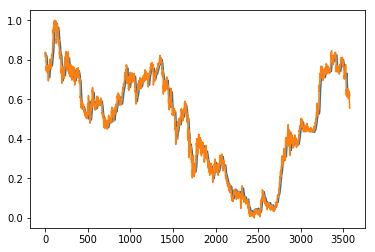

In [119]:
y_pred = model.predict(train['data'])
plt.plot(y_pred)
plt.plot(train['target'])

In [125]:
y_pred = model.predict(test['data'])

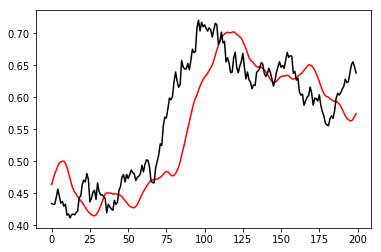

In [128]:
plt.plot(y_pred[80:280], c='red')
plt.plot(test['target'][80:280], c='k')

学習失敗．高周波フィルタリングに相当．